<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
<center>
Авторы материала: Виталий Радченко (YouScan) и Юрий Кашницкий (Mail.Ru Group).

Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №5
## <center> Случайный лес и логистическая регрессия в задачах кредитного скоринга и классификации отзывов к фильмам

#### Нашей главной задачей будет построение и настройка моделей для задач кредитного скоринга и анализа отзывов к фильмам. Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1s17pqYJ1kUez7F_c0qHDLYpucL5XMs9QWK4JgTfxk9E/edit).

Но для разминки решите первое задание.

**<font color='red'>Задание 1.</font>** В зале суда есть 7 присяжных, каждый из них по отдельности с вероятностью 80% может правильно определить, виновен подсудимый или нет. С какой вероятностью присяжные все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

**<font color='red'>Варианты ответа:</font>**
- 20.97%
- 80.00%
- 83.70%
- 96.66%

Теперь перейдем непосредственно к машинному обучению.

### Ответ: 96.66



#### Данные по кредитному скорингу представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	– Человек имел долгие просрочки выплат платежей за 2 года; бинарный признак

##### Независимые признаки
* age	                         – Возраст заёмщика кредитных средств (число полных лет); тип – integer
* NumberOfTime30-59DaysPastDueNotWorse	– Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней (но не больше) в течение последних двух лет; тип -	integer
* DebtRatio –	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип – float
* MonthlyIncome	– Месячный доход в долларах; тип –	float
* NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип –	integer
* NumberOfTime60-89DaysPastDueNotWorse –	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней (но не больше) в течение последних двух лет; тип – integer
* NumberOfDependents – Число человек в семье кредитозаёмщика; тип –	integer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Напишем функцию, которая будет заменять значения NaN на медиану в каждом столбце таблицы. 

In [3]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Считываем данные

In [4]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Рассмотрим типы считанных данных

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение классов в зависимой переменной

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

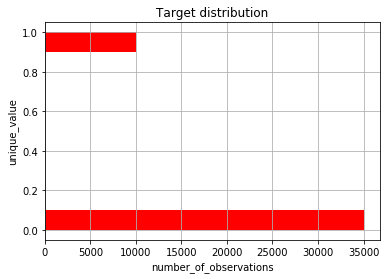

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Выберем названия всех признаков, кроме прогнозируемого

In [7]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Применяем функцию, заменяющую все значения NaN на медианное значение соответствующего столбца.

In [8]:
table = impute_nan_with_median(data)

Разделяем целевой признак и все остальные – получаем обучающую выборку. 

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [192]:
X.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,64,0,0.249908,0,0,8158.0,0.0
1,58,0,3870.000000,0,0,5166.0,0.0
2,41,0,0.456127,0,0,6666.0,0.0
3,43,0,0.000190,0,0,10500.0,2.0
4,49,0,0.271820,0,0,400.0,0.0


Выведем версии основных библиотек – результат `GridSearchCV`, например, может отличаться в разных версиях `sklearn` даже при фиксированном `random_state`.

In [8]:
#!pip install watermark
%load_ext watermark

In [9]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.6.3
IPython 6.2.1

numpy 1.14.0
scipy 1.0.0
pandas 0.21.1
matplotlib 2.1.1
sklearn 0.19.0

compiler   : GCC 4.2.1 (Apple Inc. build 5666) (dot 3)
system     : Darwin
release    : 17.4.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 9c88536a782617680d2006de6be65790cd5aa576


# Бутстрэп

**<font color='red'>Задание 2.</font>** Сделайте интервальную оценку (на основе бутстрэпа) среднего дохода (MonthlyIncome) клиентов, просрочивших выплату кредита, и отдельно – для вовремя заплативших. Стройте 90% доверительный интервал. Найдите разницу между нижней границей полученного интервала для не просрочивших кредит и верхней границей – для просрочивших. 
То есть вас просят построить 90%-ые интервалы для дохода "хороших" клиентов $[good\_income\_lower, good\_income\_upper]$ и для "плохих" – $[bad\_income\_lower, bad\_income\_upper]$ и найти разницу $good\_income\_lower - bad\_income\_upper$.

Используйте пример из [статьи](https://habrahabr.ru/company/ods/blog/324402/). Поставьте `np.random.seed(17)`. Округлите ответ до целых.

**<font color='red'>Варианты ответа:</font>**
- 345
- 425
- 585
- 655

In [10]:
np.random.seed(17)

def get_bootstrap_samples(data, n_samples, seed=17):
    # функция для генерации подвыборок с помощью бутстрэпа
    np.random.seed(seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [11]:
overdue_credit = data[data.SeriousDlqin2yrs == 1]['MonthlyIncome'].values
not_overdue_credit = data[data.SeriousDlqin2yrs == 0]['MonthlyIncome'].values

overdue_credit_boot_means = [np.mean(values) for values in get_bootstrap_samples(overdue_credit, 1000)] 
not_overdue_credit_boot_means = [np.mean(values) for values in get_bootstrap_samples(not_overdue_credit, 1000)] 

bad_income_lower, bad_income_upper = stat_intervals(overdue_credit_boot_means, 0.1)
good_income_lower, good_income_upper = stat_intervals(not_overdue_credit_boot_means, 0.1)

good_income_lower - bad_income_upper

654.7281617306935

### Ответ: 655

# Дерево решений, подбор гиперпараметров

Одной из основных метрик качества модели является площадь под ROC-кривой. Значения ROC-AUC лежат от 0 до 1. Чем ближе значение ROC-AUC к 1, тем качественнее происходит классификация моделью.

Найдите с помощью `GridSearchCV` гиперпараметры `DecisionTreeClassifier`, максимизирующие площадь под ROC-кривой. 

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Используем модуль `DecisionTreeClassifier` для построения дерева решений. Из-за несбалансированности классов  в целевом признаке добавляем параметр балансировки. Используем также параметр `random_state=17` для воспроизводимости результатов.

In [14]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

Перебирать будем вот такие значения гиперпараметров:

In [15]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Зафиксируем кросс-валидацию: стратифицированная, 5 разбиений с перемешиванием, не забываем про `random_state`.

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [19]:
from sklearn.metrics import roc_auc_score
# GridSearchCV(df, tree_params, n_jobs=-1, cv=skf, error_score='roc-auc')
gs_cv = GridSearchCV(dt, tree_params, n_jobs=-1, cv=skf, scoring ='roc_auc')
gs_cv.fit(X, y);

**<font color='red'>Задание 3.</font>**
Сделайте GridSearch с метрикой ROC AUC по гиперпараметрам из словаря `tree_params`. Какое максимальное значение ROC AUC получилось (округлите до 2 знаков после разделителя)? Назовем кросс-валидацию устойчивой, если стандартное отклонение метрики качества на кросс-валидации меньше 1%. Получилась ли кросс-валидация устойчивой при оптимальных сочетаниях гиперпараметров (т.е. обеспечивающих максимум среднего значения ROC AUC на кросс-валидации)?

In [20]:
print(gs_cv.best_score_)
print(gs_cv.best_params_)
print(gs_cv.cv_results_['std_test_score'][gs_cv.best_index_])
gs_cv.best_score_, gs_cv.cv_results_['std_test_score'][gs_cv.best_index_] < 0.01

0.8203023476209635
{'max_depth': 7, 'max_features': 6}
0.002758483553592935


(0.8203023476209635, True)

In [21]:
BEST_PARAMS = gs_cv.best_params_
BEST_PARAMS

{'max_depth': 7, 'max_features': 6}

**<font color='red'>Варианты ответа:</font>**
- 0.82, нет
- 0.84, нет
- 0.82, да
- 0.84, да

### Ответ: 82, да

# Простая реализация случайного леса

**<font color='red'>Задание 4.</font>**
Реализуйте свой собственный случайный лес с помощью `DecisionTreeClassifier` с лучшими параметрами из прошлого задания. В нашем лесу будет 10 деревьев, предсказанные вероятности которых вам нужно усреднить. 

Краткая спецификация: 
 - Используйте основу ниже
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`) фиксируйте seed, равный (`random_state + i`). Почему именно так – неважно, главное чтоб на каждой итерации seed был новый, при этом все значения можно было бы воспроизвести
 - Зафиксировав seed, выберите **без замещения** `max_features` признаков, сохраните список выбранных id признаков в `self.feat_ids_by_tree`
 - Также сделайте bootstrap-выборку (т.е. **с замещением**) из множества id объектов 
 - Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `RandomForestClassifierCustom` на выборке с нужным подмножеством объектов и признаков
 - Метод `fit` возвращает текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self`
 - В методе `predict_proba` опять нужен цикл по всем деревьям. У тестовой выборки нужно взять те признаки, на которых соответсвующее дерево обучалось, и сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [23]:
import random

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator


class RandomForestClassifierCustom(BaseEstimator):
    a = []
    def __init__(self, n_estimators=10, max_depth=3, max_features=10, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree = []
        self.feat_columns_by_tree = []
        np.random.seed(random_state)
        
    def fit(self, X, y):
        print('X.isnull', X.isnull().any().any())
        for index in range(self.n_estimators):
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth, 
                max_features=self.max_features,
                random_state=self.random_state + index,
            )
            
            # получаем разное фичи, которые будут использоваться в дереве
            count_features = self.max_features if len(X.columns) > self.max_features else len(X.columns)
            columns = random.sample(list(X.columns), count_features)
            self.feat_columns_by_tree.append(columns)
            # получаем id элементов для нового дерева
            indexes = np.random.randint(low=0, high=len(X)-1, size=len(X))
            self.a.append([indexes, columns])
            
            # получаем саму выборвку
            tree_X = X.loc[indexes, columns].values
            tree_y = y.loc[indexes].values
#             print('tree_X.isnull', tree_X.isnull().any().any())
            
#             print(indexes)
#             print(len(indexes), len(X))

            
#             print(tree_X.head())
#             print(tree_y.head())
            
            tree.fit(tree_X, tree_y)
            self.trees.append(tree)
        return self
        
    
    def predict_proba(self, X):
        predict_proba = []
        for tree_index in range(len(self.trees)):
            tree = self.trees[tree_index]
            features = self.feat_columns_by_tree[tree_index]
            predicted = tree.predict_proba(X[features])
            predict_proba.append(predicted)
        return np.mean(probas, axis=1)

In [314]:
rfcc = RandomForestClassifierCustom(**BEST_PARAMS, n_estimators=10)
# rfcc.fit(X, y);

In [308]:
RandomForestClassifierCustom.a

[array([10863, 34959, 33174, ..., 11147, 35223,  7563])]

In [322]:
indexes = np.random.randint(low=0, high=len(X)-1, size=len(X))
columns = random.sample(list(X.columns), 7)

print(X.columns)
X.loc[[1, 2, 3, 100], ['DebtRatio', 'NumberOfTimes90DaysLate', 'MonthlyIncome']]
X.iloc[[1, 2, 3, 100], [0, 2]]

# tree_X = X.loc[RandomForestClassifierCustom.a[0], columns]
# tree_y = y.loc[indexes]
# print(tree_X.isnull().any())

Index(['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse',
       'MonthlyIncome', 'NumberOfDependents'],
      dtype='object')


,age,DebtRatio
1,58,3870.000000
2,41,0.456127
3,43,0.000190
100,47,0.498124


In [347]:
cross_val_score(rfcc, X, y, cv=skf, scoring='roc_auc')

X.isnull False


/Users/nvkorolkov/.virtualenvs/ml3.6/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/nvkorolkov/.virtualenvs/ml3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

**<font color='red'>Задание 5.</font>**
Тут сравним нашу собственную реализацию случайного леса с `sklearn`-овской. Для этого воспользуйтесь `RandomForestClassifier(n_jobs=1, random_state=17)`, укажите все те же значения `max_depth` и `max_features`, что и раньше. Какое среднее значение ROC AUC на кросс-валидации мы в итоге получили? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [339]:
BEST_PARAMS

{'max_depth': 5, 'max_features': 7}

In [346]:
cross_val_score?

In [24]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(**BEST_PARAMS, random_state=17)
np.mean(cross_val_score(rfc, X, y, scoring='roc_auc'))

0.8302506555991496

### Ответ: 0.823

# Случайный лес `sklearn`, подбор гиперпараметров

**<font color='red'>Задание 6.</font>** 
В 3 задании мы находили оптимальные гиперпараметры для одного дерева, но может быть, для ансамбля эти параметры дерева не будут оптимальными. Давайте проверим это с помощью `GridSearchCV` `(RandomForestClassifier(random_state=17)`).  Только теперь расширим перебираемые значения `max_depth` до 15 включительно, так как в лесу нужны деревья поглубже (а почему именно – вы поняли из [статьи](https://habrahabr.ru/company/ods/blog/324402/)). Какими теперь стали лучшие значения гиперпараметров?

**<font color='red'>Варианты ответа:</font>**
- `max_depth=8, max_features=4`
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

In [25]:
max_depth_values = range(5, 16)
max_features_values = range(4, 8)
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [29]:
%%time

rfc = RandomForestClassifier(random_state=17)

gs_cv_rfc = GridSearchCV(rfc, forest_params, n_jobs=-1, scoring='roc_auc')
gs_cv_rfc.fit(X, y);

CPU times: user 1.52 s, sys: 94.6 ms, total: 1.62 s
Wall time: 14.7 s


In [30]:
gs_cv_rfc.best_score_

0.832451475124348

In [32]:
gs_cv_rfc.best_params_

{'max_depth': 8, 'max_features': 4}

# Логистическая регрессия, подбор гиперпараметров

**<font color='red'>Задание 7.</font>**  Теперь сравним с логистической регрессией (укажем `class_weight='balanced'` и `random_state=17`). Сделайте полный перебор по параметру `C` из широкого диапазона значений `np.logspace(-8, 8, 17)`. 
Только сделаем это корректно и выстроим пайплайн – сначала масштабирование, затем обучение модели. 

Разберитесь с пайплайнами и проведите кросс-валидацию. Какое получилось лучшее значение средней ROC AUC? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.778
- 0.788
- 0.798
- 0.808

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [34]:
logit_gs = GridSearchCV(logit_pipe, param_grid=logit_pipe_params, scoring='roc_auc', n_jobs=-1)
logit_gs.fit(X, y);

In [35]:
logit_gs.best_score_

0.788064415514781

### Ответ: 0.778

# Логистическая регрессия и случайный лес на разреженных признаках

В случае небольшого числа признаков случайный лес показал себя лучше логистической регрессии. Однако один из главных недостатков деревьев проявляется при работе с разреженным данными, например с текстами. Давайте сравним логистическую регрессию и случайный лес в новой задаче.
Скачайте данные с отзывами к фильмам [отсюда](https://drive.google.com/open?id=12OPgwkx5Q63iqxXGR3MqZQpiMev_aB7g).

In [378]:
# Загрузим данные
df = pd.read_csv("../../data/movie_reviews_train.csv", nrows=50000)

# Разделим данные на текст и целевой признак
X_text = df["text"]
y_text = df["label"]

# Соотношения классов
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [379]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# будем разбивать на 3 фолда
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# в Pipeline будем сразу преобразовать наш текст и обучать логистическую регрессию
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', LogisticRegression(random_state=17))
])

**<font color='red'>Задание 8.</font>** Сделайте полный перебор по параметру `C` из выборки [0.1, 1, 10, 100]. Какое лучшее значение ROC AUC получилось на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [386]:
%%time

log_params = {'clf__C': [0.1, 1, 10, 100]}
logistic_text = GridSearchCV(classifier, param_grid=log_params, cv=skf, score='roc-auc', n_jobs=-1)
logistic_text.fit(X_text, y_text);

CPU times: user 11.3 s, sys: 448 ms, total: 11.8 s
Wall time: 42.5 s


In [387]:
logistic_text.best_score_

0.7951

### Ответ: 0.84  (ближе) 

**<font color='red'>Задание 9.</font>** Теперь попробуем сравнить со случайным лесом. Аналогично делаем перебор и получаем максимальное ROC AUC. Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [390]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [388]:
RandomForestClassifier?

In [392]:
%%time

forst_grid_params = {
    'clf__min_samples_leaf': min_samples_leaf,
    'clf__max_features': max_features,
    'clf__max_depth': max_depth,
}
forest_text_grcv = GridSearchCV(classifier, n_jobs=-1, cv=skf, param_grid=forst_grid_params)
forest_text_grcv.fit(X_text, y_text);

In [393]:
forest_text_grcv.best_score_

0.71422

### Ответ: 0.74